In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras 
from scipy.stats import entropy
import sys
sys.path.append('..')
sys.path.append('../odcd/cd/')
sys.path.append('../odcd/utils/')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib
import seaborn as sns
from creme.stats import Mean, Var
import matplotlib.pyplot as plt
import model_symmetries as vsf
%matplotlib inline

from skmultiflow.drift_detection.adwin import ADWIN

import streaming_sim_test as sst
from importlib import reload

import colorama
from colorama import Fore, Style

Using TensorFlow backend.


In [2]:
def prepare_data_wines(path_white='/home/fdz/git/concept_drift_exps/data/wine/winequality_white.csv',
                     path_red='/home/fdz/git/concept_drift_exps/data/wine/winequality_red.csv',
                     binary_target=True, scale=True, permute=True, perm_features=5):
    
    df_white = pd.read_csv(path_white)
    df_white['quality'].value_counts() / len(df_white)
    
    if binary_target:
        df_white['target'] = df_white['quality'].apply(lambda x: 0 if x < 6 else 1)
    else:
        df_white['target'] = df_white['quality']
    df_white.drop('quality', axis=1, inplace=True)
    target = 'target'
    # print('White distribution', df_white[target].value_counts() / len(df_white))
    
    features = [col for col in df_white.columns if col != target]
    X, y = df_white[features].values, df_white[target].values
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    
    if scale:
        scaler = MinMaxScaler()
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
    
    y_train = tf.keras.utils.to_categorical(y_train)
    y_test = tf.keras.utils.to_categorical(y_test)
    
    y_train = np.delete(y_train, np.where(~y_train.any(axis=0)), axis=1)
    y_test = np.delete(y_test, np.where(~y_test.any(axis=0)), axis=1)
    
    df_red = pd.read_csv(path_red)
    df_red['quality'].value_counts() / len(df_red)
    
    if binary_target:
        df_red['target'] = df_red['quality'].apply(lambda x: 0 if x < 6 else 1)
    else:
        df_red['target'] = df_red['quality']
    df_red.drop('quality', axis=1, inplace=True)
    target = 'target'
    # print('Red distribution ', df_red[target].value_counts() / len(df_red))
    
    features = [col for col in df_red.columns if col != target]
    X_red, y_red = df_red[features].values, df_red[target].values
    if scale:
        X_red = scaler.transform(X_red)
    
    y_red = tf.keras.utils.to_categorical(y_red)
    y_red = np.delete(y_red, np.where(~y_red.any(axis=0)), axis=1)
    
    if not permute:
        return df_white, df_red, X_train, y_train, X_test, y_test, X_red, y_red 
    else:
        perm_1 = np.random.permutation(range(11))[:perm_features]
        perm_2 = np.random.permutation(range(11))[:perm_features]
        
        X_cd = X_test.copy()
        X_cd[:, perm_1] = X_cd[:, perm_2]
        
        y_cd = y_test
        return df_white, df_red, X_train, y_train, X_test, y_test, X_cd, y_cd 

def model_wines(binary_target=True, nb_units=100):
    
    x_in = tf.keras.layers.Input(shape=(11, ))
    x = tf.keras.layers.Dense(nb_units, activation='relu')(x_in)
    #x = tf.keras.layers.Dense(50, activation='relu')(x_in)
    if binary_target:
        out = tf.keras.layers.Dense(2, activation='softmax')(x)
    else:
        out = tf.keras.layers.Dense(7, activation='softmax')(x)
    clf = tf.keras.models.Model(x_in, out)
    clf.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    
    clf.summary()
    return clf

# Data prep

In [37]:
df_white, df_red, X_train, y_train, X_test, y_test, X_cd, y_cd = prepare_data_wines(path_white='/home/Gigio/git/fork-odcd/data/wine/winequality_white.csv',
                                                                                    path_red='/home/Gigio/git/fork-odcd/data/wine/winequality_red.csv',
                                                                                    permute=True, perm_features=4)

# Train model

In [20]:
clf = model_wines(nb_units=200)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 11)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 200)               2400      
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 402       
Total params: 2,802
Trainable params: 2,802
Non-trainable params: 0
_________________________________________________________________


In [21]:
clf.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

Train on 3673 samples, validate on 1225 samples
Epoch 1/100
3673/3673 [==============================] - 1s 168us/step - loss: 0.5951 - acc: 0.6665 - val_loss: 0.5386 - val_acc: 0.7233
Epoch 2/100
3673/3673 [==============================] - 0s 78us/step - loss: 0.5426 - acc: 0.7095 - val_loss: 0.5125 - val_acc: 0.7445
Epoch 3/100
3673/3673 [==============================] - 0s 78us/step - loss: 0.5220 - acc: 0.7326 - val_loss: 0.5019 - val_acc: 0.7584
Epoch 4/100
3673/3673 [==============================] - 0s 79us/step - loss: 0.5119 - acc: 0.7405 - val_loss: 0.4983 - val_acc: 0.7600
Epoch 5/100
3673/3673 [==============================] - 0s 78us/step - loss: 0.5081 - acc: 0.7454 - val_loss: 0.5217 - val_acc: 0.7429
Epoch 6/100
3673/3673 [==============================] - 0s 80us/step - loss: 0.5057 - acc: 0.7433 - val_loss: 0.5016 - val_acc: 0.7633
Epoch 7/100
3673/3673 [==============================] - 0s 79us/step - loss: 0.5037 - acc: 0.7520 - val_loss: 0.4920 - val_acc: 0.7682

3673/3673 [==============================] - 0s 78us/step - loss: 0.4556 - acc: 0.7846 - val_loss: 0.4678 - val_acc: 0.7886
Epoch 61/100
3673/3673 [==============================] - 0s 77us/step - loss: 0.4556 - acc: 0.7816 - val_loss: 0.4658 - val_acc: 0.7780
Epoch 62/100
3673/3673 [==============================] - 0s 78us/step - loss: 0.4560 - acc: 0.7803 - val_loss: 0.4706 - val_acc: 0.7861
Epoch 63/100
3673/3673 [==============================] - 0s 78us/step - loss: 0.4586 - acc: 0.7792 - val_loss: 0.4639 - val_acc: 0.7796
Epoch 64/100
3673/3673 [==============================] - 0s 80us/step - loss: 0.4565 - acc: 0.7822 - val_loss: 0.4740 - val_acc: 0.7780
Epoch 65/100
3673/3673 [==============================] - 0s 77us/step - loss: 0.4556 - acc: 0.7833 - val_loss: 0.4635 - val_acc: 0.7771
Epoch 66/100
3673/3673 [==============================] - 0s 80us/step - loss: 0.4546 - acc: 0.7833 - val_loss: 0.4681 - val_acc: 0.7845
Epoch 67/100
3673/3673 [==============================

### Evaluate

In [38]:
print('Train')
sst.evaluate(clf, X_train, y_train)
print('Test')
sst.evaluate(clf, X_test, y_test)
print('cd')
sst.evaluate(clf, X_cd, y_cd)

Train
Accuracy: 0.7870950176967056
Confusion matrix: [[ 868  421]
 [ 361 2023]]
Test
Accuracy: 0.7951020408163265
Confusion matrix: [[287 127]
 [124 687]]
cd
Accuracy: 0.56
Confusion matrix: [[364 492]
 [ 47 322]]


# Symmetries

In [39]:
vae = vsf.VaeSymmetryFinder(clf, input_shape=(11, ), output_shape=(2, ), intermediate_dim=128, latent_dim=4)

Vae
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 11)           0                                            
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 11)           0           encoder_input[0][0]              
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 128)          1536        reshape_2[0][0]                  
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 4)            516         dense_10[0][0]                   
__________________________________________________________________________________________________
z_log_

In [40]:
vae.fit(X_train, x_test=X_test, epochs=100)

Train on 3673 samples, validate on 1225 samples
Epoch 1/100
3673/3673 [==============================] - 1s 171us/step - loss: 0.2812 - val_loss: 0.2087
Epoch 2/100
3673/3673 [==============================] - 0s 25us/step - loss: 0.2080 - val_loss: 0.2010
Epoch 3/100
3673/3673 [==============================] - 0s 25us/step - loss: 0.2002 - val_loss: 0.1944
Epoch 4/100
3673/3673 [==============================] - 0s 24us/step - loss: 0.1953 - val_loss: 0.1916
Epoch 5/100
3673/3673 [==============================] - 0s 25us/step - loss: 0.1943 - val_loss: 0.1921
Epoch 6/100
3673/3673 [==============================] - 0s 25us/step - loss: 0.1944 - val_loss: 0.1895
Epoch 7/100
3673/3673 [==============================] - 0s 25us/step - loss: 0.1904 - val_loss: 0.1838
Epoch 8/100
3673/3673 [==============================] - 0s 25us/step - loss: 0.1834 - val_loss: 0.1816
Epoch 9/100
3673/3673 [==============================] - 0s 25us/step - loss: 0.1763 - val_loss: 0.1600
Epoch 10/100
36

3673/3673 [==============================] - 0s 25us/step - loss: 0.0018 - val_loss: 0.0021
Epoch 79/100
3673/3673 [==============================] - 0s 25us/step - loss: 0.0018 - val_loss: 0.0022
Epoch 80/100
3673/3673 [==============================] - 0s 26us/step - loss: 0.0018 - val_loss: 0.0023
Epoch 81/100
3673/3673 [==============================] - 0s 25us/step - loss: 0.0018 - val_loss: 0.0019
Epoch 82/100
3673/3673 [==============================] - 0s 26us/step - loss: 0.0017 - val_loss: 0.0022
Epoch 83/100
3673/3673 [==============================] - 0s 26us/step - loss: 0.0016 - val_loss: 0.0019
Epoch 84/100
3673/3673 [==============================] - 0s 25us/step - loss: 0.0016 - val_loss: 0.0019
Epoch 85/100
3673/3673 [==============================] - 0s 25us/step - loss: 0.0016 - val_loss: 0.0018
Epoch 86/100
3673/3673 [==============================] - 0s 27us/step - loss: 0.0017 - val_loss: 0.0019
Epoch 87/100
3673/3673 [==============================] - 0s 27us/st

In [41]:
vae.save(arch_path='vae_arch_wine.json', weights_path='vae_weights_wine.h5')

In [42]:
vae_loaded = vsf.load_vae(arch_path='vae_arch_wine.json', weights_path='vae_weights_wine.h5')

Loaded model from disk


# Stream

In [43]:
# Symmetry signal
X_train_perm = np.random.permutation(X_train)
X_test_perm = np.random.permutation(X_test)
X_cd_perm = np.random.permutation(X_cd)

amp = 100
kl_train = amp * vae_loaded.signal(X_train_perm)
kl_test = amp * vae_loaded.signal(X_test_perm)
kl_cd = amp * vae_loaded.signal(X_cd_perm)

baseline_std_plus = kl_train.mean() + kl_train.std()
baseline_std_minus = kl_train.mean() - kl_train.std()

kl_concat = np.concatenate((kl_test, kl_cd))
tr = kl_test.shape[0]

### Sudden drift

In [44]:
df = sst.make_data_stream(kl_concat, agg='mean')

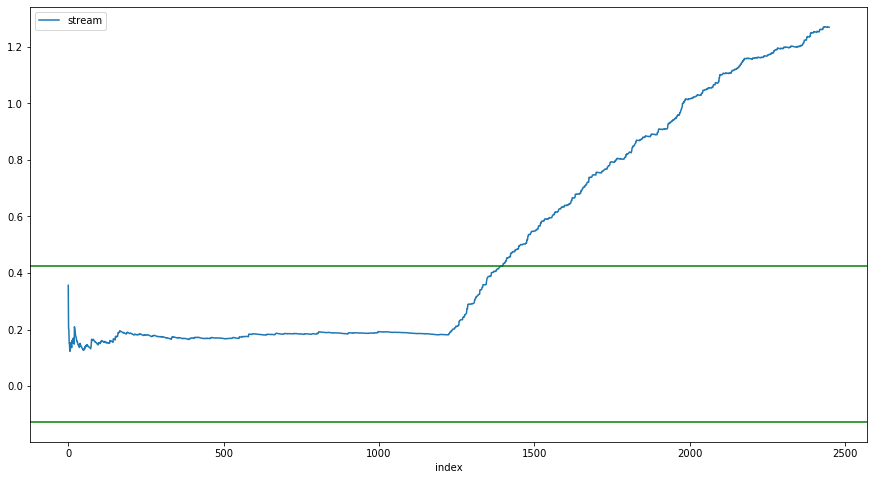

In [45]:
ax = df.plot(x='index', y='stream', figsize=(15,8))
ax.axhline(baseline_std_plus, c='g')
ax.axhline(baseline_std_minus, c='g')

In [46]:
adwin = ADWIN(delta=0.002)
data_stream = df['stream']
for i in range(len(data_stream)):
    adwin.add_element(data_stream[i])
    if adwin.detected_change():
        if i < tr:
            print(Fore.RED + 'Change detected in data: ' + str(data_stream[i]) + ' - at index: ' + str(i))
        else:
            print(Fore.GREEN + 'Change detected in data: ' + str(data_stream[i]) + ' - at index: ' + str(i))

Change detected in data: 0.4418957160384678 - at index: 1407
Change detected in data: 0.48213704899678317 - at index: 1439
Change detected in data: 0.5027733902712709 - at index: 1471
Change detected in data: 0.5916003294424979 - at index: 1535
Change detected in data: 0.6389219722438185 - at index: 1599
Change detected in data: 0.7095436002128994 - at index: 1663
Change detected in data: 0.7675493193376324 - at index: 1727
Change detected in data: 0.8091763604307026 - at index: 1791
Change detected in data: 0.8904243770352361 - at index: 1887
Change detected in data: 1.0055350803546383 - at index: 1983
Change detected in data: 1.0219800618790542 - at index: 2015
Change detected in data: 1.1058952265585016 - at index: 2111
Change detected in data: 1.1176313613793514 - at index: 2143
Change detected in data: 1.1656263312782231 - at index: 2239
Change detected in data: 1.1979033957173266 - at index: 2303
Change detected in data: 1.2131559137469101 - at index: 2367


### Gradual drift

In [58]:
cd_start = 500
cd_full = int(2 * cd_start)
nb_samples_tot = 2000
start = 0
df = sst.rolling_stats(vae, X_test, y_test, X_cd, y_cd, cd_start, cd_full, nb_samples_tot, start)

Sample 0 of 2000
Sample 1000 of 2000


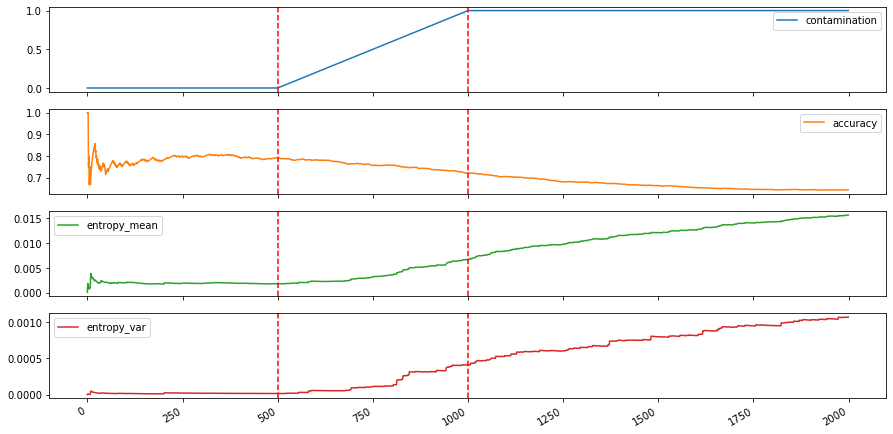

In [59]:
# Signal NOT apmlified
axs = df[['contamination', 'accuracy','entropy_mean', 'entropy_var']].plot(logy = False, subplots=True, figsize = (15, 8))
for ax in axs:
    ax.axvline(cd_start, c='r', linestyle='dashed')
    ax.axvline(cd_full, c='r', linestyle='dashed')

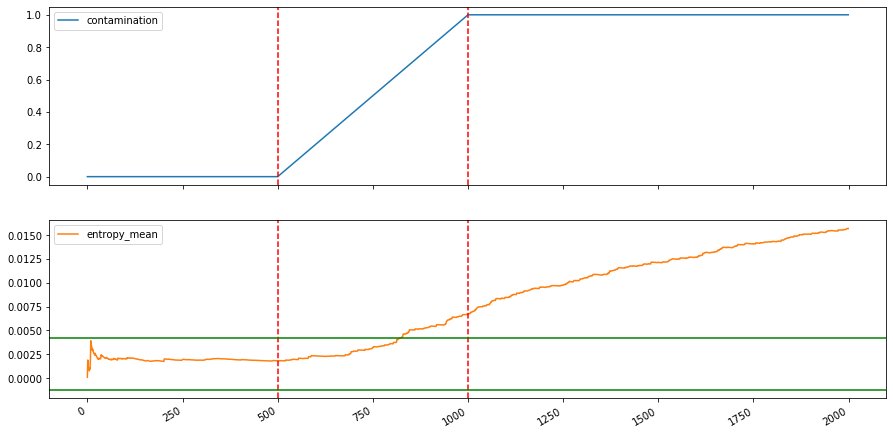

In [62]:
axs = df[['contamination', 'entropy_mean']].plot(logy = False, subplots=True, figsize = (15, 8))
for ax in axs:
    ax.axvline(cd_start, c='r', linestyle='dashed')
    ax.axvline(cd_full, c='r', linestyle='dashed')
axs[1].axhline(baseline_std_plus / amp, c='g')
axs[1].axhline(baseline_std_minus / amp, c='g')

In [63]:
data_stream = amp * df['entropy_mean']
adwin = ADWIN(delta=0.00002)
for i in range(len(data_stream)):
    adwin.add_element(data_stream[i])
    if adwin.detected_change():
        if i < cd_start:
            print(Fore.RED + 'Change detected in data: ' + str(data_stream[i]) + ' - at index: ' + str(i))
        elif i >= cd_start and i < cd_full:
            print(Fore.YELLOW + 'Change detected in data: ' + str(data_stream[i]) + ' - at index: ' + str(i))            
        else:
            print(Fore.GREEN + 'Change detected in data: ' + str(data_stream[i]) + ' - at index: ' + str(i))

Change detected in data: 0.532870470785391 - at index: 895
Change detected in data: 0.5581149304646256 - at index: 927
Change detected in data: 0.6391033791671432 - at index: 959
Change detected in data: 0.6669728090373386 - at index: 991
Change detected in data: 0.7339280963792655 - at index: 1023
Change detected in data: 0.8752678803477916 - at index: 1119
Change detected in data: 0.9150489393389999 - at index: 1151
Change detected in data: 0.9736113353831578 - at index: 1247
Change detected in data: 1.0525102803100936 - at index: 1311
Change detected in data: 1.1545955090002475 - at index: 1407
Change detected in data: 1.1957194370046904 - at index: 1471
Change detected in data: 1.2438291867519289 - at index: 1535
Change detected in data: 1.268591720840845 - at index: 1599
Change detected in data: 1.3695908833055426 - at index: 1695
Change detected in data: 1.4169389214259793 - at index: 1759
Change detected in data: 1.4791203351243318 - at index: 1855
Change detected in data: 1.518

----

# Old

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras 
import matplotlib
%matplotlib inline

/home/fdz/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/fdz/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/fdz/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/fdz/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: 

In [2]:
tf.__version__

'1.13.1'

In [3]:
import sys

In [4]:
sys.path.append('../odcd/cd/')

In [5]:
import model_symmetries as vsf

In [6]:
from scipy.stats import entropy

# Data prep

In [7]:
df_white = pd.read_csv('/home/fdz/git/concept_drift_exps/data/wine/winequality_white.csv')

In [8]:
df_white.shape

(4898, 12)

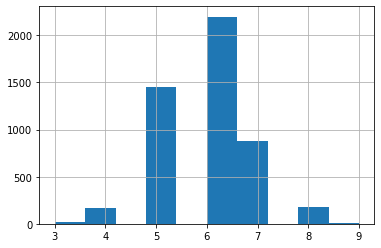

In [9]:
df_white['quality'].hist(bins=10)

In [10]:
df_white['quality'].value_counts() / len(df_white)

6    0.448755
5    0.297468
7    0.179665
8    0.035729
4    0.033279
3    0.004083
9    0.001021
Name: quality, dtype: float64

In [11]:
binary_target = True
if binary_target:
    df_white['target'] = df_white['quality'].apply(lambda x: 0 if x < 6 else 1)
else:
    df_white['target'] = df_white['quality']
df_white.drop('quality', axis=1, inplace=True)
target = 'target'
df_white[target].value_counts() / len(df_white)

1    0.665169
0    0.334831
Name: target, dtype: float64

In [12]:
features = [col for col in df_white.columns if col != target]

In [13]:
X, y = df_white[features].values, df_white[target].values

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [16]:
from sklearn.preprocessing import MinMaxScaler

In [17]:
scale = True
if scale:
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

In [18]:
freq = (df_white[target].value_counts() / len(df_white)).values

In [19]:
samples_weights = [1/freq[i] for i in y_train]

In [20]:
samples_weights = np.asarray(samples_weights)

# Logistic regression

In [21]:
from sklearn.linear_model import LogisticRegression

In [22]:
lg = LogisticRegression()
lg.fit(X_train, y_train)

/home/fdz/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [23]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [24]:
y_preds_train = lg.predict(X_train)
y_preds_test = lg.predict(X_test)

In [25]:
accuracy_score(y_preds_train, y_train)

0.756057718486251

In [26]:
confusion_matrix(y_preds_train, y_train)

array([[ 609,  275],
       [ 621, 2168]])

In [27]:
accuracy_score(y_preds_test, y_test)

0.7281632653061224

In [28]:
confusion_matrix(y_preds_test, y_test)

array([[183, 106],
       [227, 709]])

# Gxb

In [29]:
from xgboost import XGBClassifier

In [30]:
xgb = XGBClassifier(max_depth=10, n_estimators=100)

In [31]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [32]:
y_preds_train = xgb.predict(X_train)
y_preds_test = xgb.predict(X_test)

In [33]:
accuracy_score(y_preds_train, y_train)

0.9970051728832018

In [34]:
confusion_matrix(y_preds_train, y_train)

array([[1220,    1],
       [  10, 2442]])

In [35]:
accuracy_score(y_preds_test, y_test)

0.8130612244897959

In [36]:
confusion_matrix(y_preds_test, y_test)

array([[274,  93],
       [136, 722]])

# NN

In [37]:
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [38]:
y_train = np.delete(y_train, np.where(~y_train.any(axis=0)), axis=1)
y_test = np.delete(y_test, np.where(~y_test.any(axis=0)), axis=1)

In [39]:
def model():
    
    x_in = tf.keras.layers.Input(shape=(11, ))
    x = tf.keras.layers.Dense(100, activation='relu')(x_in)
    #x = tf.keras.layers.Dense(50, activation='relu')(x_in)
    if binary_target:
        out = tf.keras.layers.Dense(2, activation='softmax')(x)
    else:
        out = tf.keras.layers.Dense(7, activation='softmax')(x)
    clf = tf.keras.models.Model(x_in, out)
    clf.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    
    clf.summary()
    return clf

In [40]:
clf = model()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 11)                0         
_________________________________________________________________
dense (Dense)                (None, 100)               1200      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 202       
Total params: 1,402
Trainable params: 1,402
Non-trainable params: 0
_________________________________________________________________


In [41]:
np.where(~y_test.any(axis=0))

(array([], dtype=int64),)

In [42]:
print(y_train.shape, y_test.shape)

(3673, 2) (1225, 2)


In [43]:
samples_weights

array([1.5033763 , 1.5033763 , 1.5033763 , ..., 2.98658537, 2.98658537,
       2.98658537])

In [44]:
clf.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Train on 3673 samples, validate on 1225 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
3673/3673 [==============================] - 0s 60us/sample - loss: 0.6042 - acc: 0.6659 - val_loss: 0.5697 - val_acc: 0.6841
Epoch 2/10
3673/3673 [==============================] - 0s 24us/sample - loss: 0.5487 - acc: 0.7065 - val_loss: 0.5378 - val_acc: 0.7127
Epoch 3/10
3673/3673 [==============================] - 0s 23us/sample - loss: 0.5244 - acc: 0.7351 - val_loss: 0.5267 - val_acc: 0.7216
Epoch 4/10
3673/3673 [==============================] - 0s 23us/sample - loss: 0.5129 - acc: 0.7427 - val_loss: 0.5182 - val_acc: 0.7241
Epoch 5/10
3673/3673 [==============================] - 0s 25us/sample - loss: 0.5081 - acc: 0.7517 - val_loss: 0.5166 - val_acc: 0.7273
Epoch 6/10
3673/3673 [==============================] - 0s 25us/sample - loss: 0.5044 - acc: 0.7547 - val_loss: 0.5229 - val_acc: 0.7355
Epoch 7/10
3673/3673 [==============================] - 0s 25us/sample - loss: 0.5

In [45]:
y_preds_train = clf.predict(X_train)
y_preds_test = clf.predict(X_test)

In [46]:
y_train, y_test = np.argmax(y_train, axis=1), np.argmax(y_test, axis=1)
y_preds_train, y_preds_test = np.argmax(y_preds_train, axis=1), np.argmax(y_preds_test, axis=1)

In [47]:
accuracy_score(y_preds_train, y_train)

0.7639531717941737

In [48]:
confusion_matrix(y_preds_train, y_train)

array([[ 586,  223],
       [ 644, 2220]])

In [49]:
accuracy_score(y_preds_test, y_test)

0.7330612244897959

In [50]:
confusion_matrix(y_preds_test, y_test)

array([[169,  86],
       [241, 729]])

# Symmetry finder test

### Data prep red

In [51]:
df_red = pd.read_csv('/home/fdz/git/concept_drift_exps/data/wine/winequality_red.csv')

In [52]:
df_red.shape

(1599, 12)

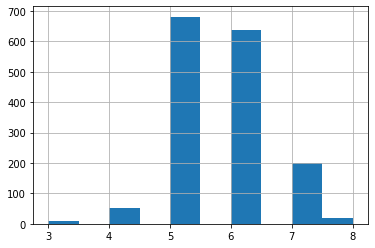

In [53]:
df_red['quality'].hist(bins=10)

In [54]:
df_red['quality'].value_counts() / len(df_red)

5    0.425891
6    0.398999
7    0.124453
4    0.033146
8    0.011257
3    0.006254
Name: quality, dtype: float64

In [55]:
if binary_target:
    df_red['target'] = df_red['quality'].apply(lambda x: 0 if x < 6 else 1)
else:
    df_red['target'] = df_red['quality']
df_red.drop('quality', axis=1, inplace=True)
target = 'target'
df_red[target].value_counts() / len(df_red)

1    0.534709
0    0.465291
Name: target, dtype: float64

In [56]:
features = [col for col in df_red.columns if col != target]

In [57]:
X_red, y_red = df_red[features].values, df_red[target].values

In [58]:
if scale:
    X_red = scaler.transform(X_red)

In [59]:
y_preds_red  = clf.predict(X_red)

In [60]:
y_preds_red = np.argmax(y_preds_red, axis=1)

In [61]:
accuracy_score(y_preds_red, y_red)

0.6560350218886805

In [62]:
confusion_matrix(y_preds_red, y_red)

array([[691, 497],
       [ 53, 358]])

In [63]:
from sklearn.metrics import precision_score, recall_score

In [64]:
precision_score(y_preds_test, y_test)

0.894478527607362

In [65]:
precision_score(y_preds_red, y_red)

0.41871345029239765

In [66]:
recall_score(y_preds_test, y_test)

0.7515463917525773

In [67]:
recall_score(y_preds_red, y_red)

0.8710462287104623

### find symmetries

In [68]:
window = 1000

In [69]:
def sample_window(X_test, y_test, window):
    samples_rnd = np.random.choice(range(len(X_test)), window, replace=False)
    X_test_samples = X_test[samples_rnd, :]
    y_test_samples = y_test[samples_rnd]
    return X_test_samples, y_test_samples

In [70]:
from importlib import reload

In [72]:
tf.__version__

'1.13.1'

In [73]:
vae = vsf.VaeSymmetryFinder(clf, input_shape=(11,), output_shape=(2, ), intermediate_dim=512)

Vae
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 11)           0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 11)           0           encoder_input[0][0]              
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 512)          6144        reshape[0][0]                    
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense_2[0][0]                    
__________________________________________________________________________________________________
z_log_

In [74]:
vae.fit(X_train, x_test=X_test, epochs=10)

Train on 3673 samples, validate on 1225 samples
Epoch 1/10
3673/3673 [==============================] - 0s 89us/sample - loss: 0.1326 - val_loss: 0.1223
Epoch 2/10
3673/3673 [==============================] - 0s 16us/sample - loss: 0.1076 - val_loss: 0.0771
Epoch 3/10
3673/3673 [==============================] - 0s 17us/sample - loss: 0.0425 - val_loss: 0.0237
Epoch 4/10
3673/3673 [==============================] - 0s 17us/sample - loss: 0.0128 - val_loss: 0.0062
Epoch 5/10
3673/3673 [==============================] - 0s 17us/sample - loss: 0.0038 - val_loss: 0.0024
Epoch 6/10
3673/3673 [==============================] - 0s 19us/sample - loss: 0.0017 - val_loss: 0.0012
Epoch 7/10
3673/3673 [==============================] - 0s 17us/sample - loss: 0.0011 - val_loss: 8.3181e-04
Epoch 8/10
3673/3673 [==============================] - 0s 19us/sample - loss: 8.0437e-04 - val_loss: 6.7495e-04
Epoch 9/10
3673/3673 [==============================] - 0s 21us/sample - loss: 6.4321e-04 - val_loss

In [75]:
vae.save()

In [142]:
reload(vsf)

<module 'model_symmetries' from '../odcd/cd/model_symmetries.py'>

In [143]:
vae_loaded = vsf.load_vae(arch_path='vae_arch.json', weights_path='vae_weights.h5')

Loaded model from disk


In [144]:
X_test[:1]

array([[0.33653846, 0.15819209, 0.18072289, 0.11656442, 0.13013699,
        0.13937282, 0.45939675, 0.18295739, 0.5462963 , 0.25925926,
        0.24193548]])

In [145]:
vae_loaded.transform(X_test[:2])

array([[0.59437466, 0.        , 0.        , 0.10507409, 0.        ,
        0.14077802, 0.24426079, 0.        , 0.        , 0.        ,
        0.04811002],
       [0.7266091 , 0.        , 0.        , 0.08965912, 0.        ,
        0.07782449, 0.2970873 , 0.        , 0.        , 0.        ,
        0.05895159]], dtype=float32)

In [146]:
X_test[:2]

array([[0.33653846, 0.15819209, 0.18072289, 0.11656442, 0.13013699,
        0.13937282, 0.45939675, 0.18295739, 0.5462963 , 0.25925926,
        0.24193548],
       [0.16346154, 0.33333333, 0.22891566, 0.01687117, 0.09246575,
        0.05226481, 0.20649652, 0.08309235, 0.50925926, 0.17283951,
        0.40322581]])

In [153]:
vae_loaded.signal(X)

array([0.8815918 , 1.87956226, 1.0569987 , ..., 1.14164443, 1.31926248,
       1.22970915])

In [132]:
vae_loaded.predict_original(X_test[:1])

array([[0.41493335, 0.5850667 ]], dtype=float32)

In [518]:
vae_outs_test = vae.vae.predict(X_test)
symm_samples_test = vae_outs_test[0]
orig_preds_test = vae_outs_test[1]
trans_preds_test = vae_outs_test[2]
    
kl_test = entropy(orig_preds_test.T, trans_preds_test.T)
baseline_std_plus = kl_test.mean() + kl_test.std()
baseline_std_minus = kl_test.mean() - kl_test.std()

In [519]:
mean_test = []
std_test = []
accs_test = []
baseline_stds_plus = []
baseline_stds_minus = []

for step in range(100):
    if step < 99:
        x_window, y_window = sample_window(X_test, y_test, window)
        vae_outs_test = vae.vae.predict(x_window)
        symm_samples_test = vae_outs_test[0]
        orig_preds_test = vae_outs_test[1]
        trans_preds_test = vae_outs_test[2]
    
        kl_test = entropy(orig_preds_test.T, trans_preds_test.T)
        mean_test.append(kl_test.mean())
        std_test.append(kl_test.std())
        preds_test = np.argmax(orig_preds_test, axis=1)
        accs_test.append(accuracy_score(preds_test, y_window))
    
        baseline_stds_plus.append(baseline_std_plus)
        baseline_stds_minus.append(baseline_std_minus)
    else:
        for i in range(0, len(X_red), 15):
            x_window, y_window = sample_window(X_test, y_test, window)
            rnd_idxs_red  = np.random.choice(range(len(X_red)), i)
            x_cont_red = X_red[rnd_idxs_red]
            y_cont_red = y_red[rnd_idxs_red]
            print('Number of contaminations: {} '.format(i))
            
            x_test_cont = np.concatenate((x_window, x_cont_red), axis=0)
            y_test_cont = np.concatenate((y_window, y_cont_red), axis=0)
            print(len(x_test_cont))
            vae_outs_test = vae.vae.predict(x_test_cont)
            symm_samples_test = vae_outs_test[0]
            orig_preds_test = vae_outs_test[1]
            trans_preds_test = vae_outs_test[2]
    
            kl_test = entropy(orig_preds_test.T, trans_preds_test.T)
            mean_test.append(kl_test.mean())
            std_test.append(kl_test.std())
            preds_test = np.argmax(orig_preds_test, axis=1)
            accs_test.append(accuracy_score(preds_test, y_test_cont))
            baseline_stds_plus.append(baseline_std_plus)
            baseline_stds_minus.append(baseline_std_minus)

Number of contaminations: 0 
1000
Number of contaminations: 15 
1015
Number of contaminations: 30 
1030
Number of contaminations: 45 
1045
Number of contaminations: 60 
1060
Number of contaminations: 75 
1075
Number of contaminations: 90 
1090
Number of contaminations: 105 
1105
Number of contaminations: 120 
1120
Number of contaminations: 135 
1135
Number of contaminations: 150 
1150
Number of contaminations: 165 
1165
Number of contaminations: 180 
1180
Number of contaminations: 195 
1195
Number of contaminations: 210 
1210
Number of contaminations: 225 
1225
Number of contaminations: 240 
1240
Number of contaminations: 255 
1255
Number of contaminations: 270 
1270
Number of contaminations: 285 
1285
Number of contaminations: 300 
1300
Number of contaminations: 315 
1315
Number of contaminations: 330 
1330
Number of contaminations: 345 
1345
Number of contaminations: 360 
1360
Number of contaminations: 375 
1375
Number of contaminations: 390 
1390
Number of contaminations: 405 
1405


In [520]:
df = pd.DataFrame()
df['accuracy'] = accs_test
df['entropy_mean'] = mean_test
df['entropy_std'] = std_test
df['baseline_std_plus'] = baseline_stds_plus
df['baseline_std_minus'] = baseline_stds_minus

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1f092b52d0>,
      dtype=object)

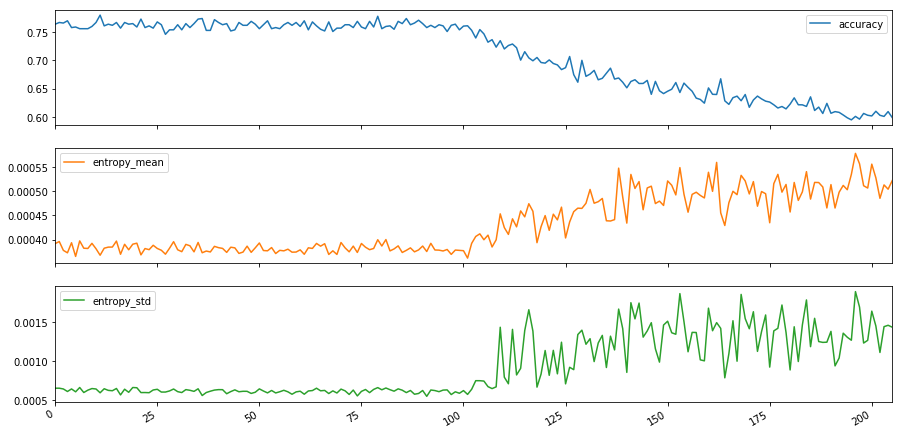

In [521]:
df[['accuracy', 'entropy_mean', 'entropy_std']].plot(logy = False, subplots=True, figsize = (15, 8))

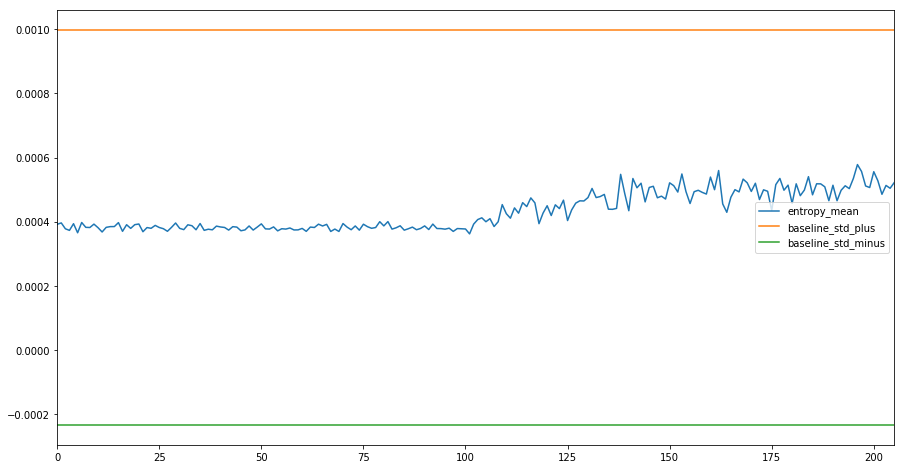

In [522]:
df[['entropy_mean', 'baseline_std_plus', 'baseline_std_minus']].plot(logy = False, subplots=False, figsize = (15, 8))

In [523]:
df.loc[97:107]

,accuracy,entropy_mean,entropy_std,baseline_std_plus,baseline_std_minus
97,0.762000,0.000370,0.000571,0.000998,-0.000234
98,0.764000,0.000379,0.000606,0.000998,-0.000234
99,0.754000,0.000378,0.000587,0.000998,-0.000234
100,0.760591,0.000377,0.000621,0.000998,-0.000234
101,0.761165,0.000362,0.000572,0.000998,-0.000234
102,0.753110,0.000392,0.000638,0.000998,-0.000234
103,0.739623,0.000407,0.000748,0.000998,-0.000234
104,0.754419,0.000412,0.000747,0.000998,-0.000234
105,0.746789,0.000400,0.000743,0.000998,-0.000234
106,0.732127,0.000409,0.000672,0.000998,-0.000234


In [524]:
X_red.shape

(1599, 11)

In [560]:
vae_outs_train = vae.vae.predict(X_train)
vae_outs_test = vae.vae.predict(X_red)

symm_samples_train = vae_outs_train[0]
orig_preds_train = vae_outs_train[1]
trans_preds_train = vae_outs_train[2]

symm_samples_test = vae_outs_test[0]
orig_preds_test = vae_outs_test[1]
trans_preds_test = vae_outs_test[2]

In [561]:
kl_train = entropy(orig_preds_train.T, trans_preds_train.T)
kl_test = entropy(orig_preds_test.T, trans_preds_test.T)

In [562]:
S_train = pd.Series(kl_train, name='train')
S_test = pd.Series(kl_test, name='test')
df_kl = pd.merge(S_train.to_frame(), S_test.to_frame(), right_index=True, left_index=True, how='outer')

0.00031513103749603033 0.0003669103025458753
0.0006002978188917041 0.0017532865749672055


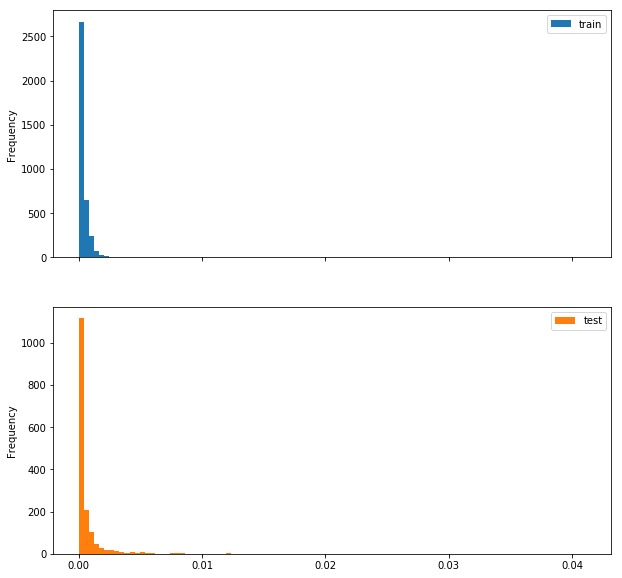

In [563]:
df_kl.plot(kind='hist', bins=100, subplots=True, figsize=(10, 10))
print(S_train.mean(), S_train.std())
print(S_test.mean(), S_test.std())

In [564]:
import matplotlib.pyplot as plt

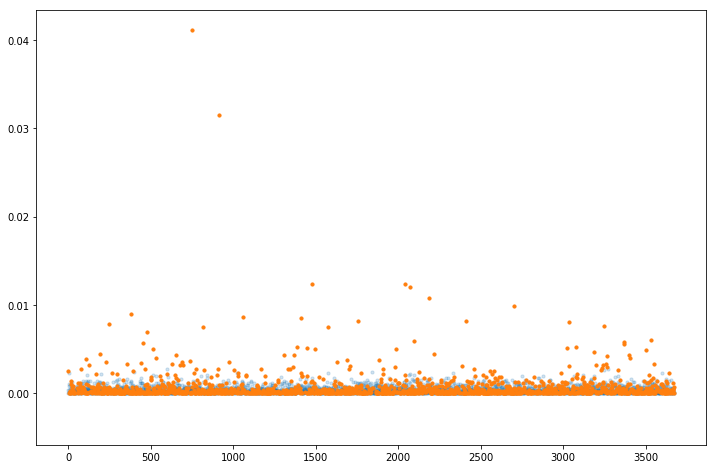

In [565]:
idx_test = np.random.permutation(pd.Series(kl_train).index)[:len(pd.Series(kl_test))]
plt.figure(figsize=(12, 8))
ax1 = plt.scatter(pd.Series(kl_train).index, pd.Series(kl_train), s=10, alpha=0.2)
ax2 = plt.scatter(idx_test, pd.Series(kl_test), s=10, alpha=1)